# Synthetic data test using the CRUST1.0 model

This notebook runs a more complex test using synthetic data generated from the CRUST1.0 model. 

We'll use this test to simulate the conditions that we expect from the real data. These conditions include: 1. unknown density contrast along the Moho, 2. having a lateraly variable density contrast, 3. unknown reference level. We'll use cross-validation (CV) to try to determine these known hyper-parameters. Unlike the CV to determine the regularization parameter, we'll use seismic point data to score solutions using different values of the hyper-parameters. We still perform the CV to determine the regularization parameter (as shown in [`synthetic-steepest-vs-newton.ipynb`](synthetic-steepest-vs-newton.ipynb). This will be a seconda layer of CV on top of that.

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import warnings
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [3]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [5]:
from tesseroid_mesh import TesseroidRelief
from datasets import fetch_assumpcao_moho_points, fetch_crust1
from moho import MohoGravityInvSpherical, cross_validation, make_mesh

Get the number of cores in this computer to run the some things in parallel.

In [6]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


## Load the CRUST1 model for South America

Get the CRUST1.0 data from the archive file and cut it to South America.

In [7]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut((-60, 20, -90, -30))

Establish a reference level for the Moho of the Normal Earth (given as height above the ellipsoid in meters, thus it is negative).

In [8]:
reference = -30e3

Now I can calculate the density contrast between the lower crust (layer number 7 in the model) and a standard mantle density of $3200\ kg/m^3$. The density contrast is negative if the true Moho is below the reference and positive otherwise.

In [9]:
moho_density_contrast = crust1.density[7] - 3200
moho_density_contrast[-crust1.moho_depth > reference] *= -1

Make a plot of the Moho depth and density contrast using an appropriate map projection.

In [10]:
area = crust1.area
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

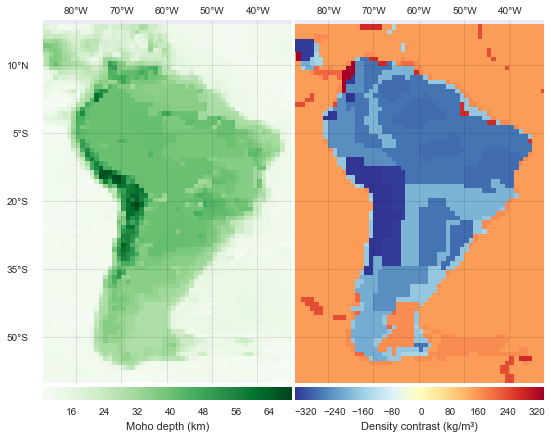

In [11]:
x, y = bm(crust1.lon, crust1.lat)

fig, axes = plt.subplots(1, 2, figsize=(7, 6), sharey='all')

plt.sca(axes[0])
bm.pcolormesh(x, y, 0.001*crust1.moho_depth, cmap='Greens')
plt.colorbar(orientation='horizontal', pad=0.01).set_label('Moho depth (km)')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)

plt.sca(axes[1])
bm.pcolor(x, y, moho_density_contrast, cmap='RdYlBu_r')
plt.colorbar(orientation='horizontal', pad=0.01).set_label(u'Density contrast (kg/m³)')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 0, 0, 0], linewidth=0.2)

plt.tight_layout(pad=0)

## Generate synthetic data

Setup the computation grid using the coordinates of the center of each cell in the model as data points.


In [12]:
lat, lon = crust1.clat.ravel(), crust1.clon.ravel()
shape = crust1.shape
print(shape)
height = 50e3*np.ones_like(lon)

(80, 60)


In [12]:
shape = (40, 30)
lat, lon, height = gridder.regular(area, shape, z=50e3)

Create a `TesseroidRelief` model of the Moho density contrast so that we can use in forward modeling.

In [13]:
model = TesseroidRelief(area, crust1.shape, relief=-crust1.moho_depth.ravel(), reference=reference, 
                        props={'density': moho_density_contrast.ravel()})

In [14]:
model = TesseroidRelief(area, crust1.shape, relief=-crust1.moho_depth.ravel(), reference=reference)
density = np.abs(moho_density_contrast).mean()*np.ones(model.size)
density[model.relief < model.reference] *= -1
model.addprop('density', density)

Calculate the synthetic data and contaminate it with pseudo-random gaussian noise.

In [15]:
data = utils.contaminate(tesseroid.gz(lon, lat, height, model, njobs=ncpu), 5, seed=0)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than 

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


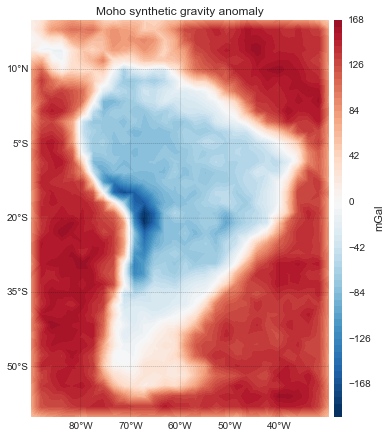

In [16]:
x, y = bm(lon, lat)
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Moho synthetic gravity anomaly')
bm.contourf(x, y, data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

## Plotting functions

In [17]:
def plot_result_maps(solver):
    # Make plots of the data fit, the estimated Moho depth, and the difference 
    # with the true values.
    predicted = solver[0].predicted()
    residuals = solver[0].residuals()
    moho = solver.estimate_
    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 25, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels, basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.6, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True)
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='RdYlBu_r')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
        
    #diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    #ranges = np.abs([diff.max(), diff.min()]).max()
    
    #plt.figure(figsize=(7, 3.5))
    #plt.title("Difference between true and estimated")  
    #bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    #plt.colorbar(pad=0.01).set_label('km')
    #bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    #bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    #plt.tight_layout(pad=0)

In [18]:
def plot_cv(regul_params, best, solution, scores, solvers, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_reference(references, best, solution, scores, cv1_results, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level)')
    plt.plot(references, scores, marker='o')
    plt.plot(references[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    if log:
        plt.yscale('log')
    plt.xlabel('Reference level (m)')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)

## Inversion setup

We need to generate a `TesseroidRelief` mesh for the inversion, give it a reference level and a density contrast. We'll assume that our mesh has the same geometry of the true model so that we can better compare the estimated and true Moho reliefs.

In [19]:
mesh = model.copy(deep=True)

In [21]:
mesh = make_mesh(area, shape, reference=reference)
density = np.abs(moho_density_contrast).mean()*np.ones(mesh.size)
density[mesh.relief < mesh.reference] *= -1
mesh.addprop('density', density)

We'll also need an initial estimate, the solver and its configuration, and a regularization object.

In [22]:
initial = -60e3*np.ones(mesh.size)  # The initial estimate doesn't really matter too much
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
config = dict(method='newton', initial=initial, tol=0.2, maxit=6)
regul = Smoothness2D(mesh.shape)

## Generate the cross-validation data

In [42]:
test_shape = [int(s*1.2) for s in shape]
print(test_shape)
test_lat, test_lon, test_h = gridder.regular(area, test_shape, z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_data = utils.contaminate(test_data, 5, seed=10)  # Use a different seed to get independent errors
test_set = [test_lat, test_lon, test_h, test_data]

[48, 36]


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than 

For this test, we'll assume that we don't know the true reference level used. We'll also consider two other scenarios:

1. Assume that we know the variable density contrast (taken from CRUST1.0)
2. Assume an unknown uniform density contrast for the Moho

We'll try to estimate both the reference level and the uniform density contrast through cross-validation. This means that there will be **two levels of cross-validation**: 

1. Testing agains the `test_set` for the regularization parameter
2. Against some other constraints for the reference level

These "other constraints" will come some point information about the Moho depth in some isolated points. In reality, these point depths could come from seismic experiments.



We'll generate some fictional point constraints by taking the true value from our Moho model. The point coordinates chosen for this come from the seismic dataset of [Assumpção et al. (2012)](http://dx.doi.org/10.1016%2Fj.tecto.2012.11.014). We'll interpolate the values of the CRUST1 Moho depth onto these points.

In [26]:
lat_points, lon_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz')[:2]

In [27]:
seismic_points = gridder.interp_at(model.clat.ravel(), model.clon.ravel(), model.relief, 
                                   lat_points, lon_points)

In [28]:
test_points = [lat_points, lon_points, seismic_points]

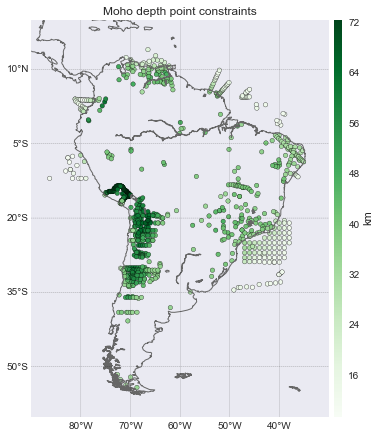

In [29]:
x, y = bm(lon_points, lat_points)

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*seismic_points, s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

Now we need a function that, given a Moho depth estimate, will calculate the Mean Square Error (MSE) between that esimate and the "seismic" constraints.

In [30]:
def score_seismic_constraints(moho, lat, lon, height):
    # moho is the estimated TesseroidRelief object given by
    # solver.estimate_. lat lon and height are the point constraints
    estimated = gridder.interp_at(moho.clat.ravel(), moho.clon.ravel(), moho.relief, 
                                  lat, lon, extrapolate=True)
    rms = np.sum((height - estimated)**2)/height.size
    return rms

We can check if our function works by feeding it the true model and the extracted points. The MSE should be zero.

In [31]:
score_seismic_constraints(model, lat_points, lon_points, seismic_points)

0.0

Now we need functions to perform the second level of cross-validation to find the reference levels and (optionally) the density constrast.

In [32]:
def _fit_score(args):
    mu, reference, misfit, regul, config, test_points = args
    solution = (misfit + mu*regul).config(**config).fit()
    score = score_seismic_constraints(solution.estimate_, *test_points)
    return score, solution

def cross_validation_regul(misfit, regul, regul_params, config, test_points):
    args = [[mu, misfit, regul, config, test_points]
            for mu in regul_params]
    results = map(_fit_score_regul, args)
    scores, solutions = zip(*results)
    return scores, solutions

def _fit_score_reference2(args):
    reference, cv_args, test_points = args
    

def _fit_score_reference(args):
    "Run cross-validation for the regularization parameter using a given reference level"
    reference, cv_args, test_points = args
    misfit = cv_args[0]
    misfit.set_reference(reference)
    cv = cross_validation(*cv_args)
    solution = cv[1]
    score = score_seismic_constraints(solution.estimate_, *test_points)
    return score, cv

def cross_validation_reference(misfit, regul, regul_params, references, config, test_set, test_points, 
                               njobs=1):
    cv_args = [misfit, regul, regul_params, config, test_set]
    args = [[ref, cv_args, test_points] for ref in references]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(_fit_score_reference, args)
        pool.close()
        pool.join()
    else:
        results = map(_fit_score_reference, args)
    scores, cv1_results = zip(*results)    
    best = np.argmin(scores)
    solution = cv1_results[best][1]
    return best, solution, scores, cv1_results

## Inversion with known variable density

In [43]:
regul_params = np.logspace(-7, -1, 10)
regul_params

array([  1.00000000e-07,   4.64158883e-07,   2.15443469e-06,
         1.00000000e-05,   4.64158883e-05,   2.15443469e-04,
         1.00000000e-03,   4.64158883e-03,   2.15443469e-02,
         1.00000000e-01])

In [44]:
reference_levels = np.linspace(-40e3, -20e3, 8, endpoint=False)
reference_levels

array([-40000., -37500., -35000., -32500., -30000., -27500., -25000.,
       -22500.])

In [45]:
with warnings.catch_warnings() as w:
    args = [misfit, regul, regul_params, reference_levels, config, test_set, test_points, ncpu]
    %time results = cross_validation_reference(*args)

CPU times: user 241 ms, sys: 118 ms, total: 359 ms
Wall time: 7min 30s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not

In [46]:
best, solution, scores, cv1_results = results

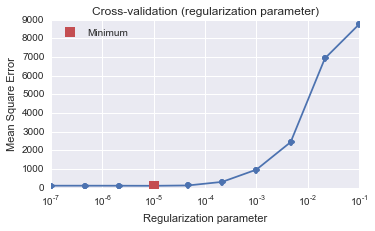

In [47]:
plot_cv(regul_params, *cv1_results[best], log=False)

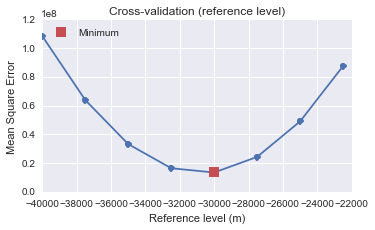

In [48]:
plot_cv_reference(reference_levels, *results, log=False)

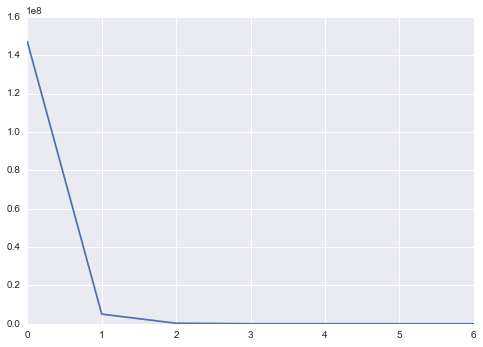

In [49]:
plt.figure()
plt.plot(solution.stats_['objective'])

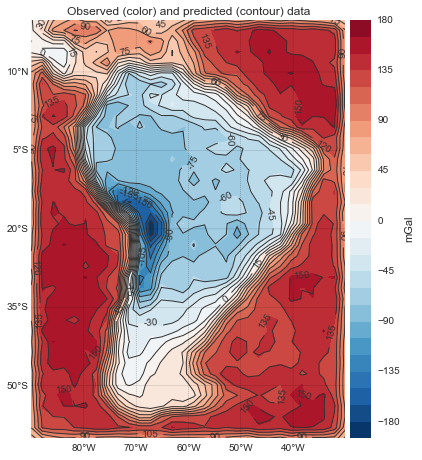

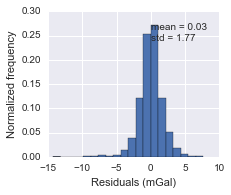

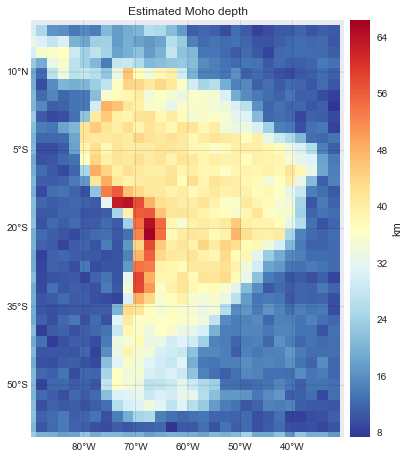

In [50]:
plot_result_maps(solution)

## Inversion with unknown uniform density